# Initialization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [4]:
%matplotlib inline

# Coding Up Color Selection

## Load Image

In [7]:
#Read image
image = mpimg.imread('./test.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)

('This image is:', <type 'numpy.ndarray'>, 'with dimensions:', (540, 960, 3))


In [8]:
ysize = image.shape[0] #height, num rows, y
xsize = image.shape[1] #width, num columns, x

In [30]:
#image[1,1] #each point is RGB, no alpha

## Simple Color Thresholding

In [31]:
#make a copy of the image
color_select = np.copy(image)

In [25]:
#define 3 thresholds
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [26]:
#define a logical function, to set any points below thresholds to 0

In [27]:
thresholds = ( (image[:,:,0] < rgb_threshold[0]) | \
               (image[:,:,1] < rgb_threshold[1]) | \
               (image[:,:,2] < rgb_threshold[2]))

In [28]:
color_select[thresholds] = [0,0,0]

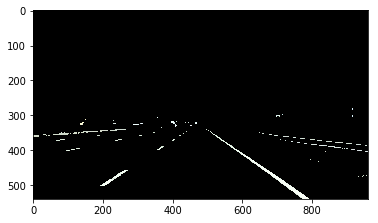

In [29]:
plt.imshow(color_select)

## Set Regions of Interest

In [73]:
region_select = np.copy(image)

In [74]:
left_bottom = [0,539] #bottom left
right_bottom = [959,539] #bottom right
apex = [480,300] #top

In [75]:
#fit 3 regression lines to identify regions of interest
# x-coords of sample pts, y-coords of sample pts
fit_left = np.polyfit(x=(left_bottom[0], apex[0]),y=(left_bottom[1], apex[1]),deg=1)
fit_right = np.polyfit(x=(right_bottom[0], apex[0]),y=(right_bottom[1], apex[1]),deg=1)
fit_bottom = np.polyfit(x=(left_bottom[0], right_bottom[0]),y=(left_bottom[1], right_bottom[1]),deg=1)

In [76]:
#We only want to examine points within this triangular area

In [77]:
#return a grid of points, X is column and Y is row
XX, YY = np.meshgrid(np.arange(0,xsize), np.arange(0,ysize)) #returns the coordinates of the image.

In [78]:
#Y is under the left fit
#Y is under the right fit
#Y is larger than baseline

region_thresholds = ((YY > (XX*fit_left[0]   + fit_left[1] )) & \
                     (YY > (XX*fit_right[0]  + fit_right[1])) & \
                     (YY < (XX*fit_bottom[0] + fit_bottom[1])))

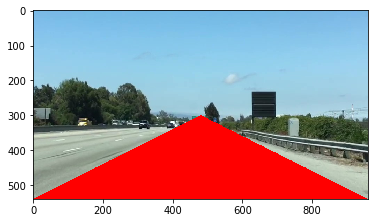

In [79]:
region_select[region_thresholds] = [255,0,0] #set to RED for regions of interest
plt.imshow(region_select)

## Combine the color and range

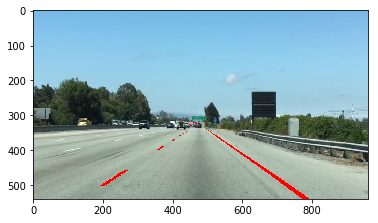

In [80]:
line_image = np.copy(image)
line_image[~thresholds & region_thresholds] = [255,0,0] #~ -> Vector not
plt.imshow(line_image)

# Edge Detection

[**Canny Edge Detection Algorithm**](https://en.wikipedia.org/wiki/Canny_edge_detector) in OpenCV

## OpenCV Edge Detector

In [98]:
import cv2
import numpy as np

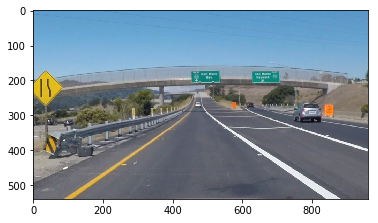

In [82]:
image = mpimg.imread('./exit-ramp.jpg')
plt.imshow(image)

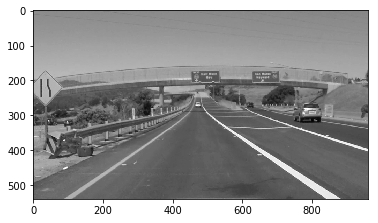

In [92]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray') #single value instead of RGB value

In [97]:
#edges = cv2.Canny(gray, low_threshold, high_threshold)
#suggested low to high ratio of 1:2 or 1:3

#Gaussian smoothing: kernal size = 3 means larger averges; the larger the smoother

In [99]:
?cv2.GaussianBlur

In [106]:
kernal_size = 3
blur_gray = cv2.GaussianBlur(gray, (kernal_size, kernal_size), 0) #last parameter is sd

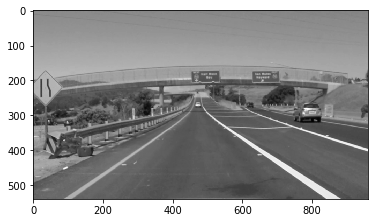

In [109]:
plt.imshow(blur_gray, cmap='gray') #use blur to reduce noise; Canny applies 5X5 Gaussian fitler by default

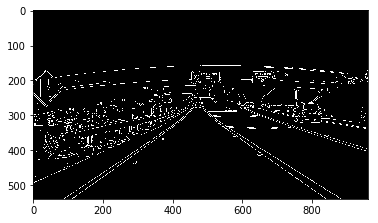

In [122]:
low_threshold = 100
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')

## Hough Transformation

$y=a\cdot x + b$

Hough transformation: a, b space, instead, in the Hough space, every point is represented as a line

$b = y - x\cdot a$

So how to find lines:
- Divide the image of sections, look for intersections in Hough space
- However the vertical lines have infinite slope, need to convert to polar space rho and theta
- Look for intersections of the sin waves in Hough space

In [125]:
### 

In [128]:
#lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
#                                             min_line_length, max_line_gap)

#rho and theta are distance and angular resolutions of our grid (remember, we are looking for # of intersections within the same grid)
#threshold: minimum # of votes

In [131]:
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1

line_image = np.copy(image) * 0 #use a blank image

#detect lines
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

In [133]:
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image, (x1,y1),(x2,y2),(255,0,0),10)

In [139]:
color_edges = np.dstack((edges, edges, edges)) #merge 3 arrays into 1; stack, vstack, hstack, concatenate, dsplit

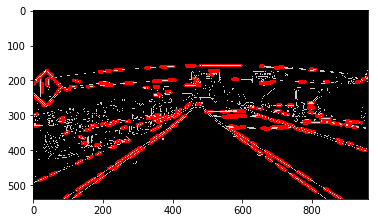

In [143]:
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) #merge two images
plt.imshow(combo) #so we can use a quadrilateral region mask

## Combine with Quadrilateral Region Mask

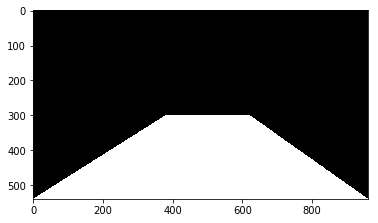

In [172]:
mask = np.zeros_like(edges) #create a same matrix with all zeros
ignore_mask_color = 255

imshape = image.shape
vertices = np.array([[(380,300),(0, imshape[0]-1), (imshape[1]-1, imshape[0]-1), (620,300)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color) #
plt.imshow(mask, cmap='gray')

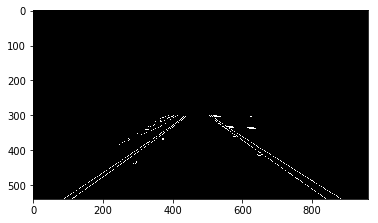

In [173]:
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap='gray')

In [174]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

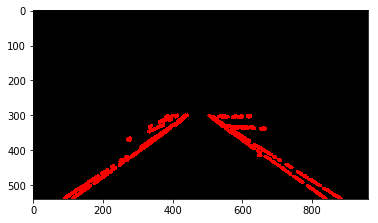

In [176]:
plt.imshow(line_image)

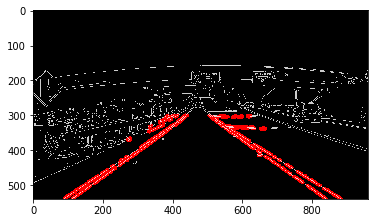

In [183]:
#This is a rule base method: detect edges, connect them and then plot the lines within a certain region in view
color_edges = np.dstack((edges, edges, edges)) 
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [186]:
#These are needed to process video
#import imageio
#imageio.plugins.ffmpeg.download()